In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_ce_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM2_species"
ood = "0:1"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 87612 images
Dataset type val label type: species


Loaded 21905 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 41868 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 55824 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:1 dydmderv


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-dydmderv:best, 58.48MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.3


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                            | 0/685 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                   | 1/685 [00:01<12:22,  1.09s/it]

  1%|█▎                                                                                                                                                  | 6/685 [00:01<01:44,  6.51it/s]

  2%|██▎                                                                                                                                                | 11/685 [00:01<00:54, 12.33it/s]

  2%|███▍                                                                                                                                               | 16/685 [00:01<00:37, 18.03it/s]

  3%|████▌                                                                                                                                              | 21/685 [00:01<00:28, 23.28it/s]

  4%|█████▌                                                                                                                                             | 26/685 [00:01<00:23, 27.83it/s]

  5%|██████▋                                                                                                                                            | 31/685 [00:01<00:20, 31.61it/s]

  5%|███████▋                                                                                                                                           | 36/685 [00:01<00:18, 34.69it/s]

  6%|████████▊                                                                                                                                          | 41/685 [00:02<00:17, 37.05it/s]

  7%|█████████▊                                                                                                                                         | 46/685 [00:02<00:16, 38.83it/s]

  7%|██████████▉                                                                                                                                        | 51/685 [00:02<00:15, 40.14it/s]

  8%|████████████                                                                                                                                       | 56/685 [00:02<00:15, 41.07it/s]

  9%|█████████████                                                                                                                                      | 61/685 [00:02<00:14, 41.77it/s]

 10%|██████████████▏                                                                                                                                    | 66/685 [00:02<00:14, 42.26it/s]

 10%|███████████████▏                                                                                                                                   | 71/685 [00:02<00:14, 42.59it/s]

 11%|████████████████▎                                                                                                                                  | 76/685 [00:02<00:14, 42.83it/s]

 12%|█████████████████▍                                                                                                                                 | 81/685 [00:02<00:14, 43.01it/s]

 13%|██████████████████▍                                                                                                                                | 86/685 [00:03<00:13, 43.12it/s]

 13%|███████████████████▌                                                                                                                               | 91/685 [00:03<00:13, 43.23it/s]

 14%|████████████████████▌                                                                                                                              | 96/685 [00:03<00:13, 43.29it/s]

 15%|█████████████████████▌                                                                                                                            | 101/685 [00:03<00:13, 43.32it/s]

 15%|██████████████████████▌                                                                                                                           | 106/685 [00:03<00:13, 43.35it/s]

 16%|███████████████████████▋                                                                                                                          | 111/685 [00:03<00:13, 43.37it/s]

 17%|████████████████████████▋                                                                                                                         | 116/685 [00:03<00:13, 43.39it/s]

 18%|█████████████████████████▊                                                                                                                        | 121/685 [00:03<00:13, 43.38it/s]

 18%|██████████████████████████▊                                                                                                                       | 126/685 [00:03<00:12, 43.41it/s]

 19%|███████████████████████████▉                                                                                                                      | 131/685 [00:04<00:12, 43.42it/s]

 20%|████████████████████████████▉                                                                                                                     | 136/685 [00:04<00:12, 43.42it/s]

 21%|██████████████████████████████                                                                                                                    | 141/685 [00:04<00:12, 43.43it/s]

 21%|███████████████████████████████                                                                                                                   | 146/685 [00:04<00:12, 43.44it/s]

 22%|████████████████████████████████▏                                                                                                                 | 151/685 [00:04<00:12, 43.42it/s]

 23%|█████████████████████████████████▏                                                                                                                | 156/685 [00:04<00:12, 43.41it/s]

 24%|██████████████████████████████████▎                                                                                                               | 161/685 [00:04<00:12, 43.43it/s]

 24%|███████████████████████████████████▍                                                                                                              | 166/685 [00:04<00:11, 43.45it/s]

 25%|████████████████████████████████████▍                                                                                                             | 171/685 [00:05<00:11, 43.46it/s]

 26%|█████████████████████████████████████▌                                                                                                            | 176/685 [00:05<00:11, 43.45it/s]

 26%|██████████████████████████████████████▌                                                                                                           | 181/685 [00:05<00:11, 43.43it/s]

 27%|███████████████████████████████████████▋                                                                                                          | 186/685 [00:05<00:11, 43.44it/s]

 28%|████████████████████████████████████████▋                                                                                                         | 191/685 [00:05<00:11, 43.45it/s]

 29%|█████████████████████████████████████████▊                                                                                                        | 196/685 [00:05<00:11, 43.43it/s]

 29%|██████████████████████████████████████████▊                                                                                                       | 201/685 [00:05<00:11, 43.41it/s]

 30%|███████████████████████████████████████████▉                                                                                                      | 206/685 [00:05<00:11, 43.42it/s]

 31%|████████████████████████████████████████████▉                                                                                                     | 211/685 [00:05<00:10, 43.44it/s]

 32%|██████████████████████████████████████████████                                                                                                    | 216/685 [00:06<00:10, 43.44it/s]

 32%|███████████████████████████████████████████████                                                                                                   | 221/685 [00:06<00:10, 43.44it/s]

 33%|████████████████████████████████████████████████▏                                                                                                 | 226/685 [00:06<00:10, 43.44it/s]

 34%|█████████████████████████████████████████████████▏                                                                                                | 231/685 [00:06<00:10, 43.43it/s]

 34%|██████████████████████████████████████████████████▎                                                                                               | 236/685 [00:06<00:10, 43.45it/s]

 35%|███████████████████████████████████████████████████▎                                                                                              | 241/685 [00:06<00:10, 43.47it/s]

 36%|████████████████████████████████████████████████████▍                                                                                             | 246/685 [00:06<00:10, 43.45it/s]

 37%|█████████████████████████████████████████████████████▍                                                                                            | 251/685 [00:06<00:09, 43.45it/s]

 37%|██████████████████████████████████████████████████████▌                                                                                           | 256/685 [00:06<00:09, 43.46it/s]

 38%|███████████████████████████████████████████████████████▋                                                                                          | 261/685 [00:07<00:09, 43.46it/s]

 39%|████████████████████████████████████████████████████████▋                                                                                         | 266/685 [00:07<00:09, 43.45it/s]

 40%|█████████████████████████████████████████████████████████▊                                                                                        | 271/685 [00:07<00:09, 43.46it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                       | 276/685 [00:07<00:09, 43.48it/s]

 41%|███████████████████████████████████████████████████████████▉                                                                                      | 281/685 [00:07<00:09, 43.46it/s]

 42%|████████████████████████████████████████████████████████████▉                                                                                     | 286/685 [00:07<00:09, 43.47it/s]

 42%|██████████████████████████████████████████████████████████████                                                                                    | 291/685 [00:07<00:09, 43.44it/s]

 43%|███████████████████████████████████████████████████████████████                                                                                   | 296/685 [00:07<00:08, 43.45it/s]

 44%|████████████████████████████████████████████████████████████████▏                                                                                 | 301/685 [00:07<00:08, 43.45it/s]

 45%|█████████████████████████████████████████████████████████████████▏                                                                                | 306/685 [00:08<00:08, 43.46it/s]

 45%|██████████████████████████████████████████████████████████████████▎                                                                               | 311/685 [00:08<00:08, 43.45it/s]

 46%|███████████████████████████████████████████████████████████████████▎                                                                              | 316/685 [00:08<00:08, 43.45it/s]

 47%|████████████████████████████████████████████████████████████████████▍                                                                             | 321/685 [00:08<00:08, 43.41it/s]

 48%|█████████████████████████████████████████████████████████████████████▍                                                                            | 326/685 [00:08<00:08, 43.40it/s]

 48%|██████████████████████████████████████████████████████████████████████▌                                                                           | 331/685 [00:08<00:08, 43.43it/s]

 49%|███████████████████████████████████████████████████████████████████████▌                                                                          | 336/685 [00:08<00:08, 43.45it/s]

 50%|████████████████████████████████████████████████████████████████████████▋                                                                         | 341/685 [00:08<00:07, 43.45it/s]

 51%|█████████████████████████████████████████████████████████████████████████▋                                                                        | 346/685 [00:09<00:07, 43.44it/s]

 51%|██████████████████████████████████████████████████████████████████████████▊                                                                       | 351/685 [00:09<00:07, 43.45it/s]

 52%|███████████████████████████████████████████████████████████████████████████▉                                                                      | 356/685 [00:09<00:07, 43.44it/s]

 53%|████████████████████████████████████████████████████████████████████████████▉                                                                     | 361/685 [00:09<00:07, 43.43it/s]

 53%|██████████████████████████████████████████████████████████████████████████████                                                                    | 366/685 [00:09<00:07, 43.44it/s]

 54%|███████████████████████████████████████████████████████████████████████████████                                                                   | 371/685 [00:09<00:07, 43.46it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▏                                                                 | 376/685 [00:09<00:07, 43.46it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▏                                                                | 381/685 [00:09<00:06, 43.45it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▎                                                               | 386/685 [00:09<00:06, 43.46it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▎                                                              | 391/685 [00:10<00:06, 43.44it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▍                                                             | 396/685 [00:10<00:06, 43.46it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▍                                                            | 401/685 [00:10<00:06, 43.46it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▌                                                           | 406/685 [00:10<00:06, 43.43it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                          | 411/685 [00:10<00:06, 43.44it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 416/685 [00:10<00:06, 43.45it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 421/685 [00:10<00:06, 43.45it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 426/685 [00:10<00:05, 43.44it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 431/685 [00:10<00:05, 43.46it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 436/685 [00:11<00:05, 43.46it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 441/685 [00:11<00:05, 43.48it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████                                                   | 446/685 [00:11<00:05, 43.48it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 451/685 [00:11<00:05, 43.47it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 456/685 [00:11<00:05, 43.44it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 461/685 [00:11<00:05, 43.43it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 466/685 [00:11<00:05, 43.44it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 471/685 [00:11<00:04, 43.46it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 476/685 [00:12<00:04, 43.46it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 481/685 [00:12<00:04, 43.46it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 486/685 [00:12<00:04, 43.45it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 491/685 [00:12<00:04, 43.44it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 496/685 [00:12<00:04, 43.44it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 501/685 [00:12<00:04, 43.45it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 506/685 [00:12<00:04, 43.48it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 511/685 [00:12<00:04, 43.43it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 516/685 [00:12<00:03, 43.43it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 521/685 [00:13<00:03, 43.43it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 526/685 [00:13<00:03, 43.43it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 531/685 [00:13<00:03, 43.43it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 536/685 [00:13<00:03, 43.44it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 541/685 [00:13<00:03, 43.46it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 546/685 [00:13<00:03, 43.46it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 551/685 [00:13<00:03, 43.45it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 556/685 [00:13<00:02, 43.46it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 561/685 [00:13<00:02, 43.46it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 566/685 [00:14<00:02, 43.44it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 571/685 [00:14<00:02, 43.45it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 576/685 [00:14<00:02, 43.42it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 581/685 [00:14<00:02, 43.43it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 586/685 [00:14<00:02, 43.43it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 591/685 [00:14<00:02, 43.43it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 596/685 [00:14<00:02, 43.44it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 601/685 [00:14<00:01, 43.44it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 606/685 [00:15<00:01, 43.43it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 611/685 [00:15<00:01, 43.42it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 616/685 [00:15<00:01, 43.44it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 621/685 [00:15<00:01, 43.45it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 626/685 [00:15<00:01, 43.44it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 631/685 [00:15<00:01, 43.43it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 636/685 [00:15<00:01, 43.43it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 641/685 [00:15<00:01, 43.44it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 646/685 [00:15<00:00, 43.42it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 651/685 [00:16<00:00, 43.42it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 656/685 [00:16<00:00, 43.44it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 661/685 [00:16<00:00, 43.44it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 666/685 [00:16<00:00, 43.44it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 671/685 [00:16<00:00, 43.45it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 676/685 [00:16<00:00, 43.45it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 681/685 [00:16<00:00, 43.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 685/685 [00:16<00:00, 40.59it/s]

train - OK


  0%|                                                                                                                                                            | 0/172 [00:00<?, ?it/s]

  1%|▊                                                                                                                                                   | 1/172 [00:00<00:32,  5.24it/s]

  3%|█████▏                                                                                                                                              | 6/172 [00:00<00:07, 22.75it/s]

  6%|█████████▍                                                                                                                                         | 11/172 [00:00<00:05, 30.93it/s]

  9%|█████████████▋                                                                                                                                     | 16/172 [00:00<00:04, 35.40it/s]

 12%|█████████████████▉                                                                                                                                 | 21/172 [00:00<00:03, 38.07it/s]

 15%|██████████████████████▏                                                                                                                            | 26/172 [00:00<00:03, 39.74it/s]

 18%|██████████████████████████▍                                                                                                                        | 31/172 [00:00<00:03, 40.85it/s]

 21%|██████████████████████████████▊                                                                                                                    | 36/172 [00:01<00:03, 41.56it/s]

 24%|███████████████████████████████████                                                                                                                | 41/172 [00:01<00:03, 42.06it/s]

 27%|███████████████████████████████████████▎                                                                                                           | 46/172 [00:01<00:02, 42.40it/s]

 30%|███████████████████████████████████████████▌                                                                                                       | 51/172 [00:01<00:02, 42.64it/s]

 33%|███████████████████████████████████████████████▊                                                                                                   | 56/172 [00:01<00:02, 42.82it/s]

 35%|████████████████████████████████████████████████████▏                                                                                              | 61/172 [00:01<00:02, 42.94it/s]

 38%|████████████████████████████████████████████████████████▍                                                                                          | 66/172 [00:01<00:02, 43.01it/s]

 41%|████████████████████████████████████████████████████████████▋                                                                                      | 71/172 [00:01<00:02, 43.08it/s]

 44%|████████████████████████████████████████████████████████████████▉                                                                                  | 76/172 [00:01<00:02, 43.09it/s]

 47%|█████████████████████████████████████████████████████████████████████▏                                                                             | 81/172 [00:02<00:02, 43.11it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                         | 86/172 [00:02<00:01, 43.09it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▊                                                                     | 91/172 [00:02<00:01, 43.11it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████                                                                 | 96/172 [00:02<00:01, 43.12it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▋                                                            | 101/172 [00:02<00:01, 43.16it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 106/172 [00:02<00:01, 43.14it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 111/172 [00:02<00:01, 43.16it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 116/172 [00:02<00:01, 43.16it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 121/172 [00:02<00:01, 43.14it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 126/172 [00:03<00:01, 43.18it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 131/172 [00:03<00:00, 43.19it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 136/172 [00:03<00:00, 43.19it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 141/172 [00:03<00:00, 43.19it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 146/172 [00:03<00:00, 43.19it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 151/172 [00:03<00:00, 43.19it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 156/172 [00:03<00:00, 43.15it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 161/172 [00:03<00:00, 43.15it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 166/172 [00:04<00:00, 43.11it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 171/172 [00:04<00:00, 43.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 172/172 [00:04<00:00, 40.62it/s]

val - OK


  0%|                                                                                                                                                            | 0/328 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                   | 1/328 [00:00<01:12,  4.48it/s]

  2%|██▋                                                                                                                                                 | 6/328 [00:00<00:15, 20.91it/s]

  3%|████▉                                                                                                                                              | 11/328 [00:00<00:10, 29.36it/s]

  5%|███████▏                                                                                                                                           | 16/328 [00:00<00:09, 34.22it/s]

  6%|█████████▍                                                                                                                                         | 21/328 [00:00<00:08, 37.21it/s]

  8%|███████████▋                                                                                                                                       | 26/328 [00:00<00:07, 39.14it/s]

  9%|█████████████▉                                                                                                                                     | 31/328 [00:00<00:07, 40.40it/s]

 11%|████████████████▏                                                                                                                                  | 36/328 [00:01<00:07, 41.26it/s]

 12%|██████████████████▍                                                                                                                                | 41/328 [00:01<00:06, 41.84it/s]

 14%|████████████████████▌                                                                                                                              | 46/328 [00:01<00:06, 42.25it/s]

 16%|██████████████████████▊                                                                                                                            | 51/328 [00:01<00:06, 42.53it/s]

 17%|█████████████████████████                                                                                                                          | 56/328 [00:01<00:06, 42.72it/s]

 19%|███████████████████████████▎                                                                                                                       | 61/328 [00:01<00:06, 42.86it/s]

 20%|█████████████████████████████▌                                                                                                                     | 66/328 [00:01<00:06, 42.95it/s]

 22%|███████████████████████████████▊                                                                                                                   | 71/328 [00:01<00:05, 43.03it/s]

 23%|██████████████████████████████████                                                                                                                 | 76/328 [00:01<00:05, 43.06it/s]

 25%|████████████████████████████████████▎                                                                                                              | 81/328 [00:02<00:05, 43.11it/s]

 26%|██████████████████████████████████████▌                                                                                                            | 86/328 [00:02<00:05, 43.12it/s]

 28%|████████████████████████████████████████▊                                                                                                          | 91/328 [00:02<00:05, 43.14it/s]

 29%|███████████████████████████████████████████                                                                                                        | 96/328 [00:02<00:05, 43.12it/s]

 31%|████████████████████████████████████████████▉                                                                                                     | 101/328 [00:02<00:05, 43.13it/s]

 32%|███████████████████████████████████████████████▏                                                                                                  | 106/328 [00:02<00:05, 43.12it/s]

 34%|█████████████████████████████████████████████████▍                                                                                                | 111/328 [00:02<00:05, 43.14it/s]

 35%|███████████████████████████████████████████████████▋                                                                                              | 116/328 [00:02<00:04, 43.14it/s]

 37%|█████████████████████████████████████████████████████▊                                                                                            | 121/328 [00:03<00:04, 43.14it/s]

 38%|████████████████████████████████████████████████████████                                                                                          | 126/328 [00:03<00:04, 43.15it/s]

 40%|██████████████████████████████████████████████████████████▎                                                                                       | 131/328 [00:03<00:04, 43.17it/s]

 41%|████████████████████████████████████████████████████████████▌                                                                                     | 136/328 [00:03<00:04, 43.17it/s]

 43%|██████████████████████████████████████████████████████████████▊                                                                                   | 141/328 [00:03<00:04, 43.16it/s]

 45%|████████████████████████████████████████████████████████████████▉                                                                                 | 146/328 [00:03<00:04, 43.16it/s]

 46%|███████████████████████████████████████████████████████████████████▏                                                                              | 151/328 [00:03<00:04, 43.16it/s]

 48%|█████████████████████████████████████████████████████████████████████▍                                                                            | 156/328 [00:03<00:03, 43.12it/s]

 49%|███████████████████████████████████████████████████████████████████████▋                                                                          | 161/328 [00:03<00:03, 43.14it/s]

 51%|█████████████████████████████████████████████████████████████████████████▉                                                                        | 166/328 [00:04<00:03, 43.14it/s]

 52%|████████████████████████████████████████████████████████████████████████████                                                                      | 171/328 [00:04<00:03, 43.16it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                   | 176/328 [00:04<00:03, 43.13it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▌                                                                 | 181/328 [00:04<00:03, 43.12it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▊                                                               | 186/328 [00:04<00:03, 43.14it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████                                                             | 191/328 [00:04<00:03, 43.15it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▏                                                          | 196/328 [00:04<00:03, 43.10it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 201/328 [00:04<00:02, 43.12it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 206/328 [00:04<00:02, 43.12it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 211/328 [00:05<00:02, 43.14it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 216/328 [00:05<00:02, 43.17it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 221/328 [00:05<00:02, 43.11it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 226/328 [00:05<00:02, 43.13it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 231/328 [00:05<00:02, 43.14it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 236/328 [00:05<00:02, 43.15it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 241/328 [00:05<00:02, 43.15it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 246/328 [00:05<00:01, 43.16it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 251/328 [00:06<00:01, 43.09it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 256/328 [00:06<00:01, 43.10it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 261/328 [00:06<00:01, 43.14it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 266/328 [00:06<00:01, 43.16it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 271/328 [00:06<00:01, 43.17it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 276/328 [00:06<00:01, 43.17it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 281/328 [00:06<00:01, 43.14it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 286/328 [00:06<00:00, 43.20it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 291/328 [00:06<00:00, 43.19it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 296/328 [00:07<00:00, 43.20it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 301/328 [00:07<00:00, 43.20it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 306/328 [00:07<00:00, 43.19it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 311/328 [00:07<00:00, 43.21it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 316/328 [00:07<00:00, 43.22it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 321/328 [00:07<00:00, 43.14it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 326/328 [00:07<00:00, 43.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 328/328 [00:07<00:00, 41.57it/s]

test InD - OK


  0%|                                                                                                                                                            | 0/437 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                   | 1/437 [00:00<01:55,  3.77it/s]

  1%|██                                                                                                                                                  | 6/437 [00:00<00:22, 18.86it/s]

  3%|███▋                                                                                                                                               | 11/437 [00:00<00:15, 27.49it/s]

  4%|█████▍                                                                                                                                             | 16/437 [00:00<00:12, 32.78it/s]

  5%|███████                                                                                                                                            | 21/437 [00:00<00:11, 36.15it/s]

  6%|████████▋                                                                                                                                          | 26/437 [00:00<00:10, 38.38it/s]

  7%|██████████▍                                                                                                                                        | 31/437 [00:00<00:10, 39.89it/s]

  8%|████████████                                                                                                                                       | 36/437 [00:01<00:09, 40.91it/s]

  9%|█████████████▊                                                                                                                                     | 41/437 [00:01<00:09, 41.60it/s]

 11%|███████████████▍                                                                                                                                   | 46/437 [00:01<00:09, 42.09it/s]

 12%|█████████████████▏                                                                                                                                 | 51/437 [00:01<00:09, 42.44it/s]

 13%|██████████████████▊                                                                                                                                | 56/437 [00:01<00:08, 42.66it/s]

 14%|████████████████████▌                                                                                                                              | 61/437 [00:01<00:08, 42.83it/s]

 15%|██████████████████████▏                                                                                                                            | 66/437 [00:01<00:08, 42.93it/s]

 16%|███████████████████████▉                                                                                                                           | 71/437 [00:01<00:08, 43.04it/s]

 17%|█████████████████████████▌                                                                                                                         | 76/437 [00:02<00:08, 43.05it/s]

 19%|███████████████████████████▏                                                                                                                       | 81/437 [00:02<00:08, 43.08it/s]

 20%|████████████████████████████▉                                                                                                                      | 86/437 [00:02<00:08, 43.10it/s]

 21%|██████████████████████████████▌                                                                                                                    | 91/437 [00:02<00:08, 43.11it/s]

 22%|████████████████████████████████▎                                                                                                                  | 96/437 [00:02<00:07, 43.13it/s]

 23%|█████████████████████████████████▋                                                                                                                | 101/437 [00:02<00:07, 43.15it/s]

 24%|███████████████████████████████████▍                                                                                                              | 106/437 [00:02<00:07, 43.12it/s]

 25%|█████████████████████████████████████                                                                                                             | 111/437 [00:02<00:07, 43.13it/s]

 27%|██████████████████████████████████████▊                                                                                                           | 116/437 [00:02<00:07, 43.16it/s]

 28%|████████████████████████████████████████▍                                                                                                         | 121/437 [00:03<00:07, 43.13it/s]

 29%|██████████████████████████████████████████                                                                                                        | 126/437 [00:03<00:07, 43.15it/s]

 30%|███████████████████████████████████████████▊                                                                                                      | 131/437 [00:03<00:07, 43.16it/s]

 31%|█████████████████████████████████████████████▍                                                                                                    | 136/437 [00:03<00:06, 43.17it/s]

 32%|███████████████████████████████████████████████                                                                                                   | 141/437 [00:03<00:06, 43.19it/s]

 33%|████████████████████████████████████████████████▊                                                                                                 | 146/437 [00:03<00:06, 43.18it/s]

 35%|██████████████████████████████████████████████████▍                                                                                               | 151/437 [00:03<00:06, 43.17it/s]

 36%|████████████████████████████████████████████████████                                                                                              | 156/437 [00:03<00:06, 43.12it/s]

 37%|█████████████████████████████████████████████████████▊                                                                                            | 161/437 [00:03<00:06, 43.14it/s]

 38%|███████████████████████████████████████████████████████▍                                                                                          | 166/437 [00:04<00:06, 43.14it/s]

 39%|█████████████████████████████████████████████████████████▏                                                                                        | 171/437 [00:04<00:06, 43.14it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                       | 176/437 [00:04<00:06, 43.07it/s]

 41%|████████████████████████████████████████████████████████████▍                                                                                     | 181/437 [00:04<00:05, 43.10it/s]

 43%|██████████████████████████████████████████████████████████████▏                                                                                   | 186/437 [00:04<00:05, 43.10it/s]

 44%|███████████████████████████████████████████████████████████████▊                                                                                  | 191/437 [00:04<00:05, 43.12it/s]

 45%|█████████████████████████████████████████████████████████████████▍                                                                                | 196/437 [00:04<00:05, 43.09it/s]

 46%|███████████████████████████████████████████████████████████████████▏                                                                              | 201/437 [00:04<00:05, 43.12it/s]

 47%|████████████████████████████████████████████████████████████████████▊                                                                             | 206/437 [00:05<00:05, 43.14it/s]

 48%|██████████████████████████████████████████████████████████████████████▍                                                                           | 211/437 [00:05<00:05, 43.16it/s]

 49%|████████████████████████████████████████████████████████████████████████▏                                                                         | 216/437 [00:05<00:05, 43.15it/s]

 51%|█████████████████████████████████████████████████████████████████████████▊                                                                        | 221/437 [00:05<00:05, 43.10it/s]

 52%|███████████████████████████████████████████████████████████████████████████▌                                                                      | 226/437 [00:05<00:04, 43.11it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▏                                                                    | 231/437 [00:05<00:04, 43.14it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                   | 236/437 [00:05<00:04, 43.17it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▌                                                                 | 241/437 [00:05<00:04, 43.17it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▏                                                               | 246/437 [00:05<00:04, 43.17it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▊                                                              | 251/437 [00:06<00:04, 43.10it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▌                                                            | 256/437 [00:06<00:04, 43.12it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▏                                                          | 261/437 [00:06<00:04, 43.13it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 266/437 [00:06<00:03, 43.14it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 271/437 [00:06<00:03, 43.14it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 276/437 [00:06<00:03, 43.16it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 281/437 [00:06<00:03, 43.09it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 286/437 [00:06<00:03, 43.17it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 291/437 [00:06<00:03, 43.17it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 296/437 [00:07<00:03, 43.16it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 301/437 [00:07<00:03, 43.17it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 306/437 [00:07<00:03, 43.19it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 311/437 [00:07<00:02, 43.19it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 316/437 [00:07<00:02, 43.20it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 321/437 [00:07<00:02, 43.18it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 326/437 [00:07<00:02, 43.19it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 331/437 [00:07<00:02, 43.20it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 336/437 [00:08<00:02, 43.19it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 341/437 [00:08<00:02, 43.18it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 346/437 [00:08<00:02, 43.17it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 351/437 [00:08<00:01, 43.19it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 356/437 [00:08<00:01, 43.19it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 361/437 [00:08<00:01, 43.16it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 366/437 [00:08<00:01, 43.16it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 371/437 [00:08<00:01, 43.17it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 376/437 [00:08<00:01, 43.16it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 381/437 [00:09<00:01, 43.00it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 386/437 [00:09<00:01, 43.07it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 391/437 [00:09<00:01, 43.10it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 396/437 [00:09<00:00, 43.12it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 401/437 [00:09<00:00, 43.12it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 406/437 [00:09<00:00, 43.09it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 411/437 [00:09<00:00, 43.14it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 416/437 [00:09<00:00, 43.16it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 421/437 [00:09<00:00, 43.17it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 426/437 [00:10<00:00, 43.19it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 431/437 [00:10<00:00, 43.11it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 436/437 [00:10<00:00, 43.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 437/437 [00:10<00:00, 41.71it/s]

test OoD - OK


  0%|                                                                                                                                                            | 0/100 [00:00<?, ?it/s]

  5%|███████▍                                                                                                                                            | 5/100 [00:00<00:02, 44.50it/s]

 10%|██████████████▋                                                                                                                                    | 10/100 [00:00<00:02, 44.59it/s]

 15%|██████████████████████                                                                                                                             | 15/100 [00:00<00:01, 44.71it/s]

 20%|█████████████████████████████▍                                                                                                                     | 20/100 [00:00<00:01, 44.77it/s]

 25%|████████████████████████████████████▊                                                                                                              | 25/100 [00:00<00:01, 44.83it/s]

 30%|████████████████████████████████████████████                                                                                                       | 30/100 [00:00<00:01, 44.87it/s]

 35%|███████████████████████████████████████████████████▍                                                                                               | 35/100 [00:00<00:01, 44.90it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                        | 40/100 [00:00<00:01, 44.92it/s]

 45%|██████████████████████████████████████████████████████████████████▏                                                                                | 45/100 [00:01<00:01, 44.93it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                         | 50/100 [00:01<00:01, 44.94it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▊                                                                  | 55/100 [00:01<00:01, 44.95it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 60/100 [00:01<00:00, 44.96it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 65/100 [00:01<00:00, 44.94it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 70/100 [00:01<00:00, 44.95it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 75/100 [00:01<00:00, 44.95it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 80/100 [00:01<00:00, 44.96it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 85/100 [00:01<00:00, 44.95it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 90/100 [00:02<00:00, 44.96it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 95/100 [00:02<00:00, 44.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.90it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(87612, 1, 64, 64) (87612, 1, 64, 64) (87612, 512) (87612, 2) (87612,)
(21905, 1, 64, 64) (21905, 1, 64, 64) (21905, 512) (21905, 2) (21905,)
(41868, 1, 64, 64) (41868, 1, 64, 64) (41868, 512) (41868, 2) (41868,)
(55824, 1, 64, 64) (55824, 1, 64, 64) (55824, 512) (55824, 2) (55824,)
(12800, 1, 64, 64) (12800, 1, 64, 64) (12800, 512) (12800, 2)


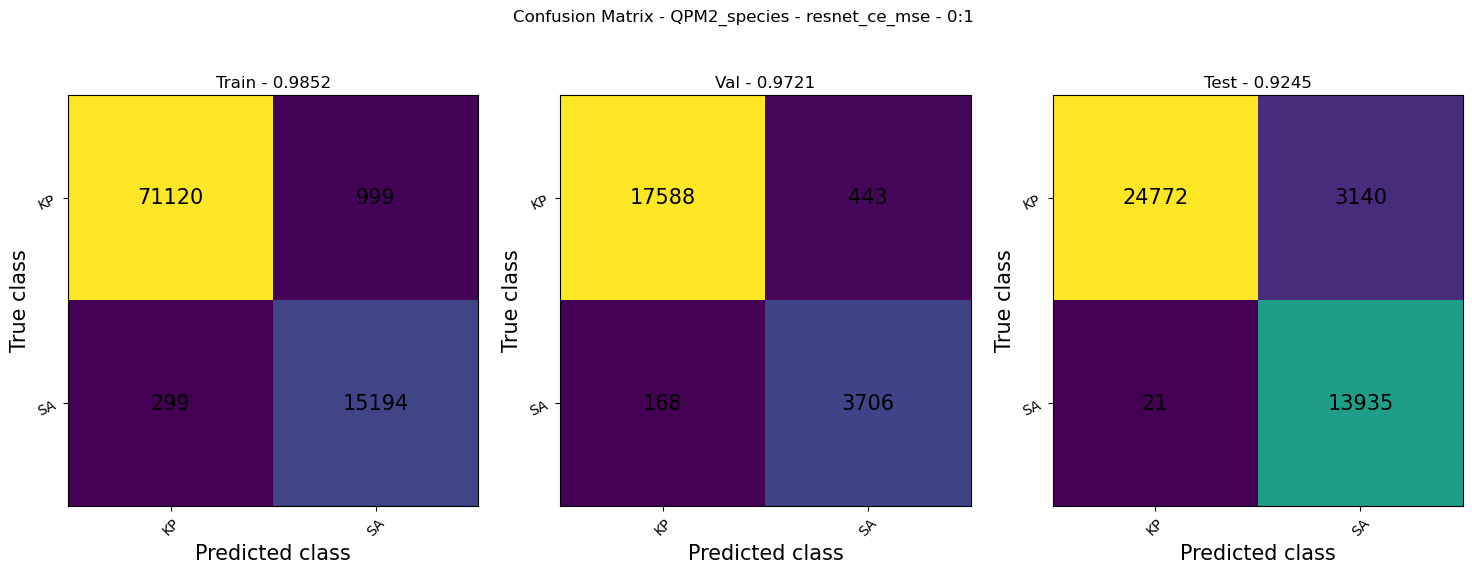

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt)).item()
run_stats.update(dict(train_acc=train_acc, val_acc=val_acc, test_acc=test_acc))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_emb.shape[0]
all_emb = ind_emb
all_lgt = ind_lgt
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb2d = umap.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

if all_lgt.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    lgt2d = umap.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(41868, 2) (55824, 2)
(41868, 2) (55824, 2)


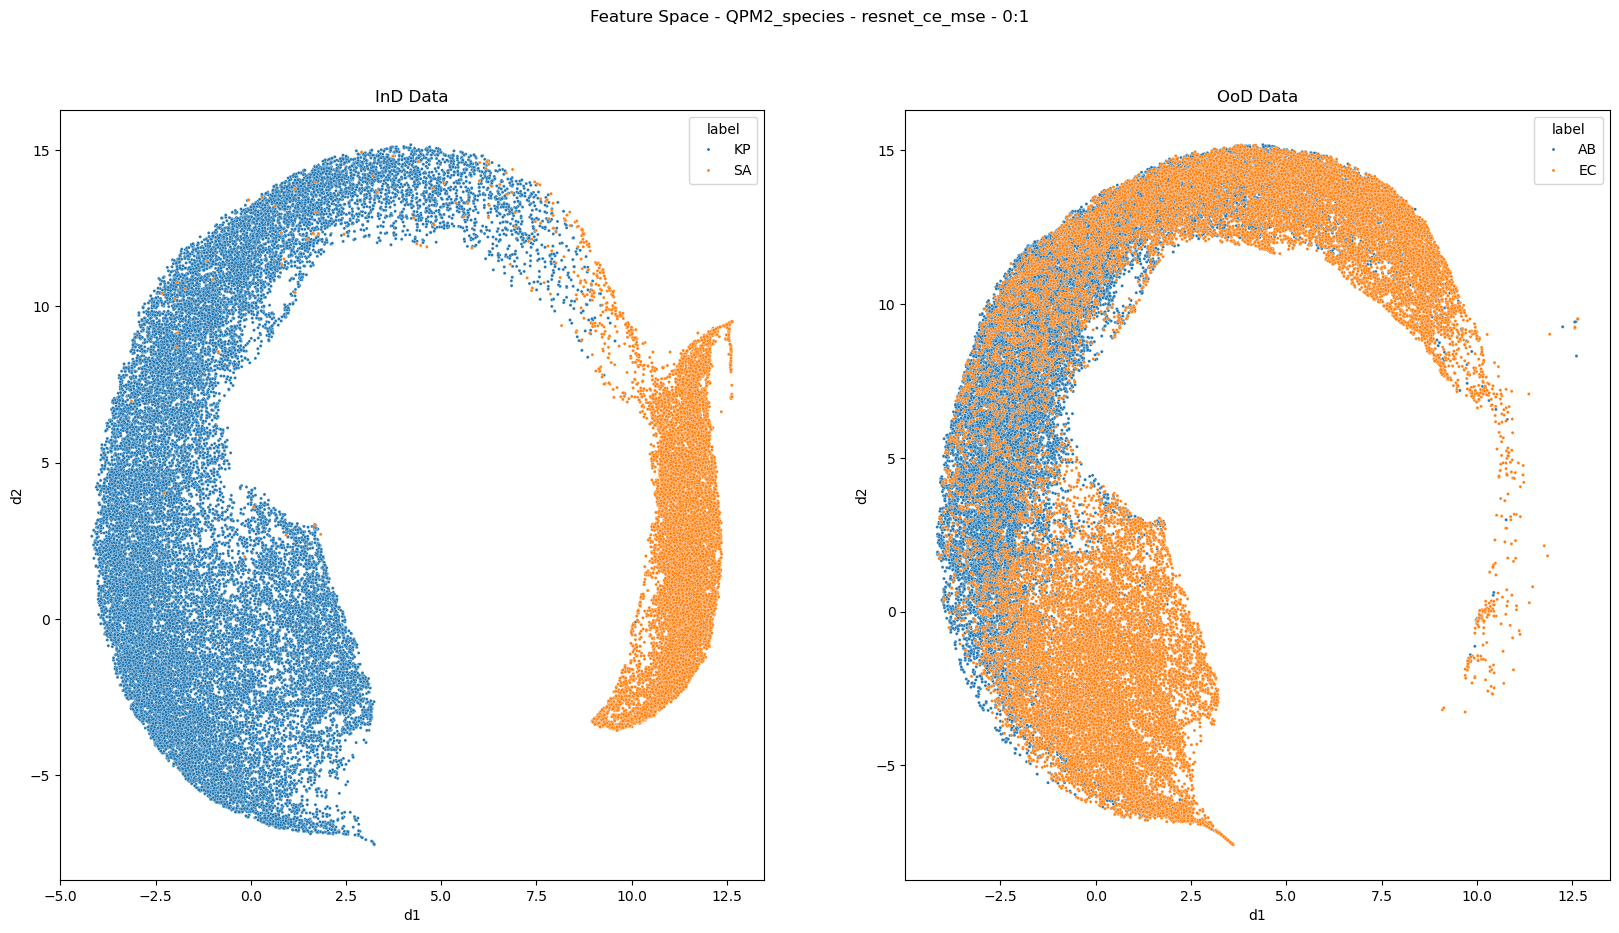

In [13]:
# plot feature space
df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

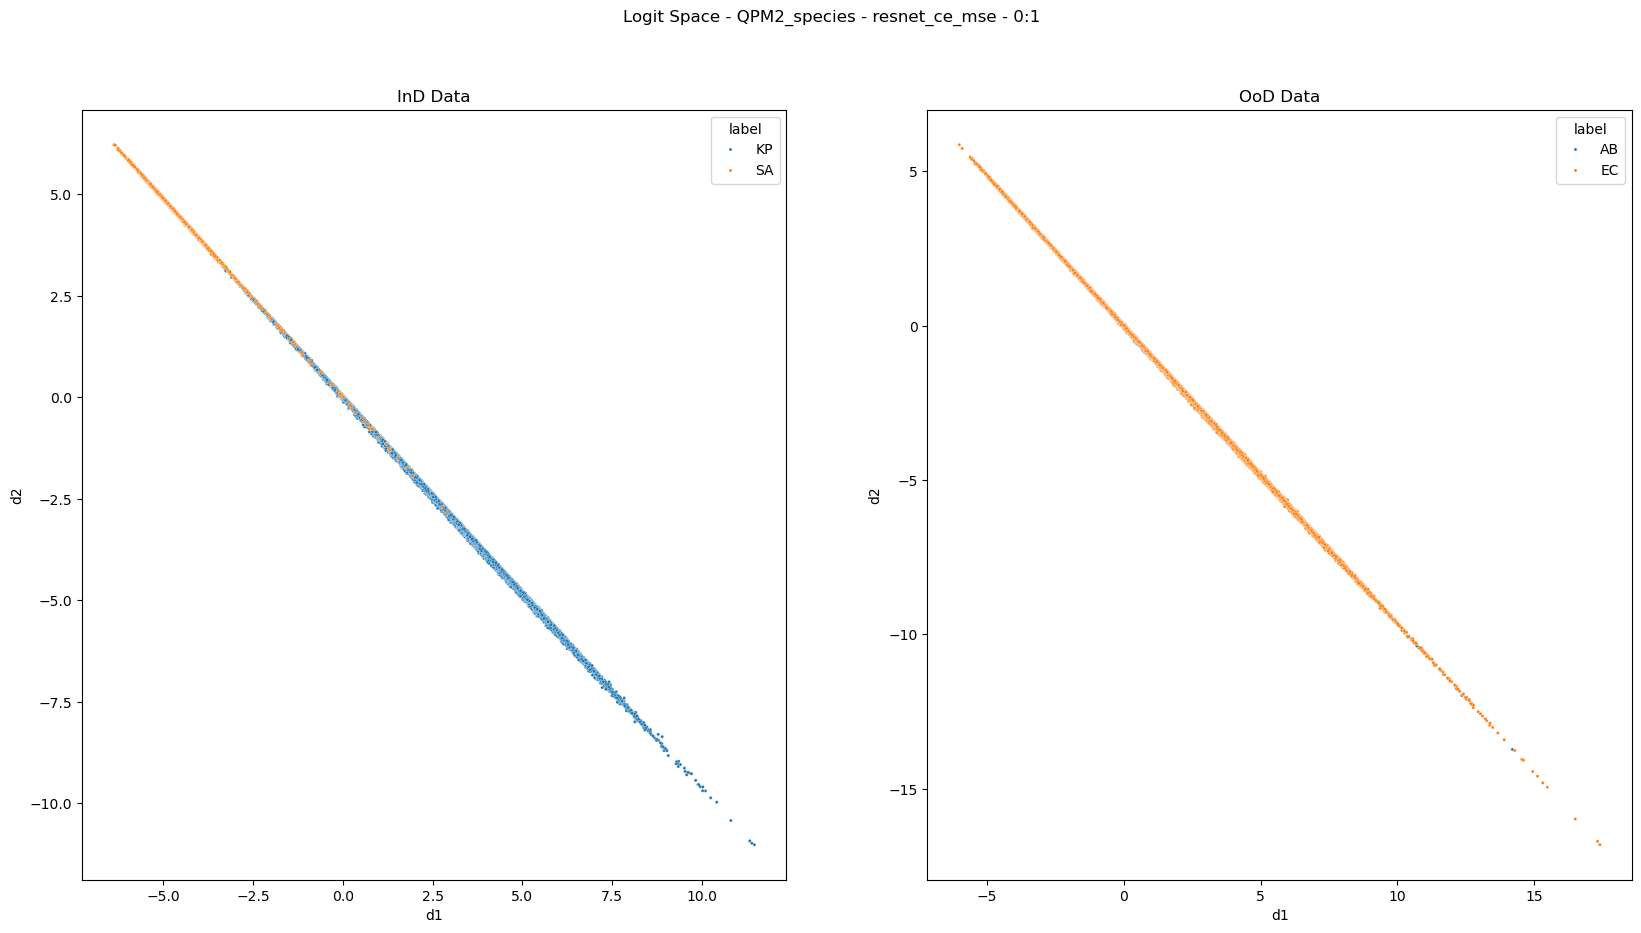

In [14]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

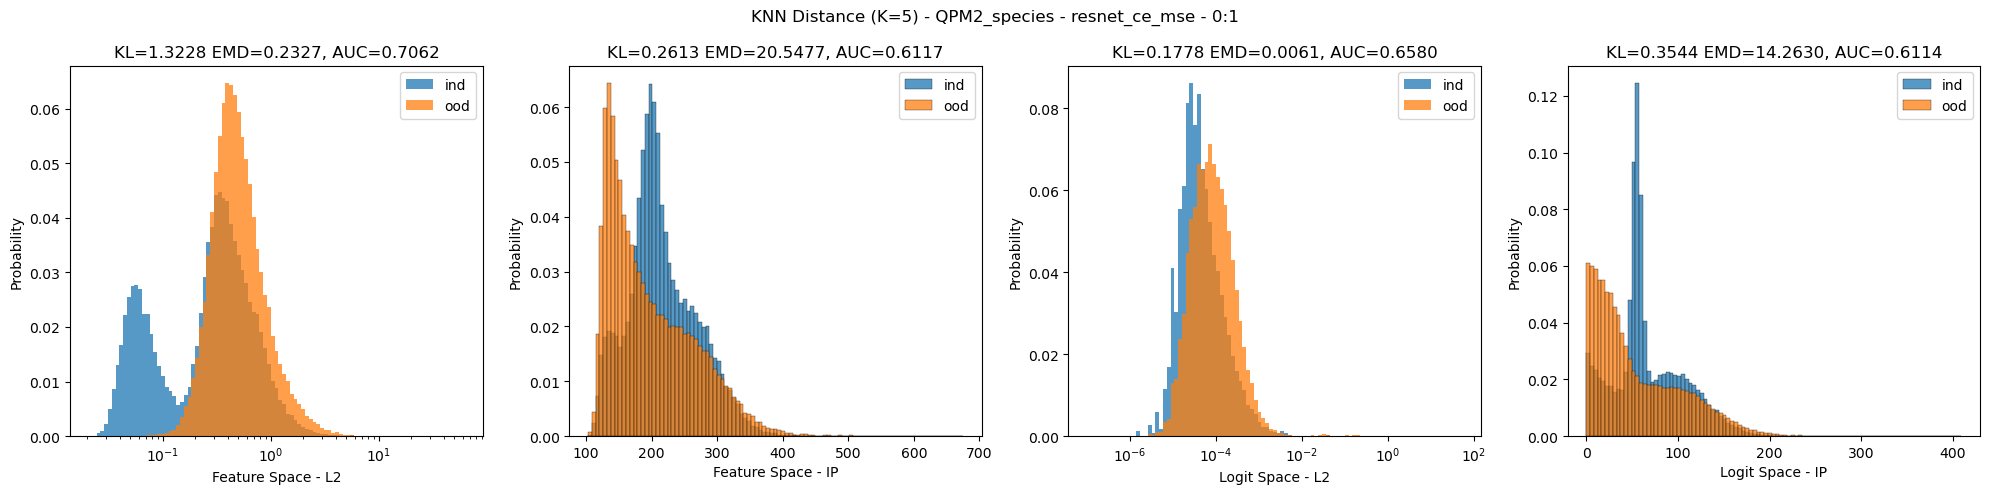

In [15]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc))
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

run_stats["knn_f_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], val_emb, ind_emb, ood_emb if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
run_stats["knn_f_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], val_emb, ind_emb, ood_emb if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
run_stats["knn_l_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="logspace")
axs[2].set_xlabel("Logit Space - L2")
run_stats["knn_l_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="linspace")
axs[3].set_xlabel("Logit Space - IP")
plt.tight_layout()
plt.show()

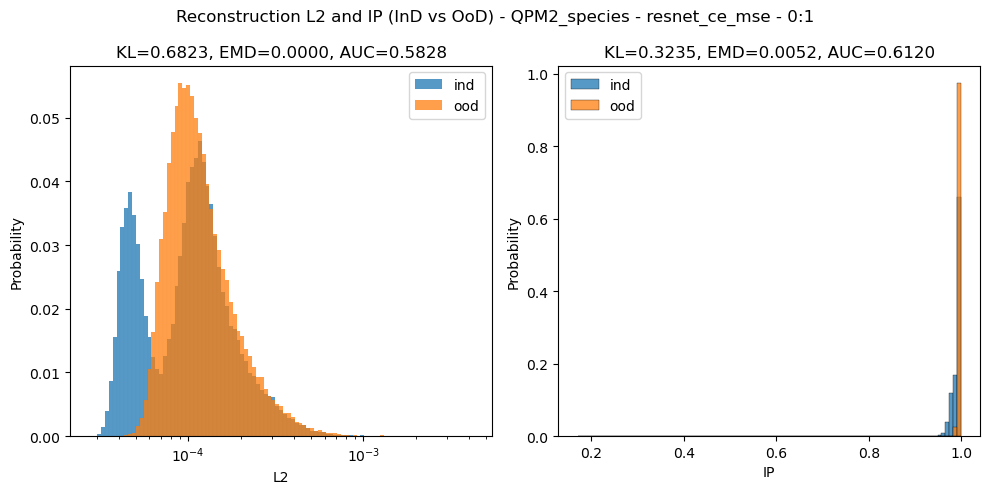

In [16]:
# plot reconstruction error of ind and ood data
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# data
_ind_inp = ind_inp.reshape((ind_inp.shape[0], -1))
_ind_rcn = ind_rcn.reshape((ind_rcn.shape[0], -1))
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # data
    _ood_inp = ood_inp.reshape((ood_inp.shape[0], -1))
    _ood_rcn = ood_rcn.reshape((ood_rcn.shape[0], -1))
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

def plot_rcn(ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

run_stats["rcn_l2"] = plot_rcn(ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

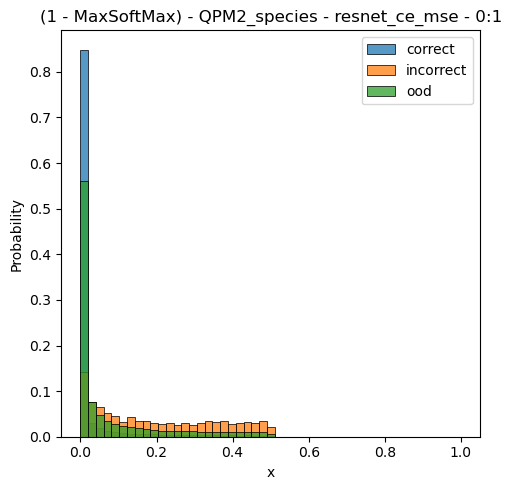

In [17]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob = np.exp(ind_lgt.astype(np.float64)) / np.exp(ind_lgt.astype(np.float64)).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt.astype(np.float64)) / np.exp(ood_lgt.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [18]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))

import json
from datetime import datetime
with open(f"assets/results/{datetime.now()}.json", "w") as f:
    json.dump(run_stats, f)